# Linear regression models

Input data: Standardized X

model1: dtsm = a0 \* dtco+a1 \* dtco ^2 + b

modeln: dtsm = a0 \* gamma + a1 \* rho + a2 \* dtco + a3 \* dtco ^2 + b

comepares LAD, Lasso, Ridge, and OLS

Modified from model_11_cv_cmp

In [ ]:
import pandas as pd
import numpy as np

from sklearn import linear_model, preprocessing, metrics
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score #, mean_absolute_percentage_error

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from ipywidgets import interact, interactive, IntSlider


current sklearn version: 0.22.2.post1 has no 'mean_absolute_precentage_error' metric

In [ ]:
data = pd. read_csv('train_wells_20210131_cln_bal.csv')

In [ ]:
data.head()

,Depth,DTSM,DTCO,GAMMA,RHO
0,5599.5,96.6386,51.8027,9.7354,2.9895
1,7633.0,97.9295,52.9170,65.4203,2.7899
2,11252.5,107.3234,59.3721,86.6629,2.5935
3,13116.5,99.6733,48.6408,16.7107,2.7033
4,6815.0,94.6977,49.2636,8.3603,2.7049


In [ ]:
data=data[(data.DTCO<140) & (data.DTSM<240)]

In [ ]:
data.describe()

,Depth,DTSM,DTCO,GAMMA,RHO
count,150625.000000,150625.000000,150625.000000,150625.000000,150625.000000
mean,8079.579824,132.023715,71.270285,82.517627,2.553487
std,3938.882276,34.998677,15.438664,44.815089,0.182163
min,559.000000,72.470100,40.459400,0.731000,1.223200
25%,5053.000000,104.310400,58.843400,46.972900,2.466800
50%,7877.000000,123.750900,70.195100,88.414200,2.589800
75%,11178.500000,151.105300,82.471600,111.434900,2.663100
max,18739.500000,239.998200,122.186300,623.161700,3.091600


In [ ]:
cols=['DTCO']
X = data[cols]
Y = data[['DTSM']]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(135562, 1) (135562, 1)
(15063, 1) (15063, 1)


## Standardization

In [ ]:
# scale
scaler_x = preprocessing.StandardScaler().fit(X_train)
X_train_sc = scaler_x.transform(X_train)
X_test_sc = scaler_x.transform(X_test)


In [ ]:
# squared term

X_train_sc=np.hstack((X_train_sc,(X_train_sc[:,-1].reshape(-1,1))**2))
X_test_sc=np.hstack((X_test_sc,(X_test_sc[:,-1].reshape(-1,1))**2))

In [ ]:
print(X_train_sc.mean(axis=0), X_train_sc.std(axis=0))
print(X_test_sc.mean(axis=0), X_test_sc.std(axis=0))


[7.96468439e-16 1.00000000e+00] [1.         1.12306941]
[6.01038752e-04 9.89452160e-01] [0.99471192 1.10019876]


In [ ]:
cols2 = cols + ['DTCO^2']
cols2

['DTCO', 'DTCO^2']

## Hyperparamter tunning with cross-validation

introducing regularization 

LASSO, Ridge, and LAD

### LAD regessor 


In [ ]:
class LADRegression(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0):
        self.alpha = alpha

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        d = X.shape[1]
        mae_loss = lambda coefs: np.mean(np.abs(y - X@coefs[:-1] - coefs[-1])) - self.alpha*np.sum(np.abs(coefs[:-1]))
        *self.coef_, self.intercept_ = minimize(mae_loss, x0=np.array((d+1)*[0.])).x # the heavy lifting
        
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        return X@self.coef_ + self.intercept_

In [ ]:
#sorted(metrics.SCORERS.keys())

In [ ]:
lad = LADRegression(alpha=0)

scoring = {'neg_mse':'neg_mean_squared_error',
           'r2':'r2'
           }

lad_scores = cross_validate(lad, X_train_sc, Y_train.DTSM, scoring=scoring,
                         cv=5, return_train_score=True)



In [ ]:
lad_mse_tr = -np.mean(lad_scores['train_neg_mse'])
lad_r2_tr = np.mean(lad_scores['train_r2'])
lad_mse_val = -np.mean(lad_scores['test_neg_mse'])
lad_r2_val = np.mean(lad_scores['test_r2'])

print("train: MSE=%.2f, R2_score=%.2f " % (lad_mse_tr, lad_r2_tr) )
print("valid: MSE=%.2f, R2_score=%.2f " % (lad_mse_val, lad_r2_val) )

train: MSE=143.06, R2_score=0.88 
valid: MSE=143.06, R2_score=0.88 


In [ ]:
lad.fit(X_train_sc,Y_train.DTSM)


LADRegression(alpha=0)

In [ ]:
for c,w in zip(cols2, lad.coef_):
  print('w_%s = %.4f' % (c,w))

print('b = %.4f' % lad.intercept_ )

w_DTCO = 31.3429
w_DTCO^2 = 5.1598
b = 127.1375


### Lasso and Ridge
GridSearchCV and Pipeline


In [ ]:
models = [('Lasso',Lasso()), ('Ridge',Ridge()),('ladr',LADRegression())]
alpha = np.append([0],np.logspace(-6, 1, 8))
param_grid =  {'alpha': alpha}

for model in models:
  search = GridSearchCV(model[1], param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
  search.fit(X_train_sc, Y_train.DTSM)

  print('\n',model[0])
  print(search.best_params_)    
  print(search.best_score_)

print('\nalpha:', alpha)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



 Lasso
{'alpha': 0.0001}
-142.61729294777496
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



 Ridge
{'alpha': 0.1}
-142.61729299678274
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.4s finished



 ladr
{'alpha': 0.0}
-143.0629728039425

alpha: [0.e+00 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]


In [ ]:
ridge = Ridge()
ridge.fit(X_train_sc, Y_train.DTSM)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
for c,w in zip(cols2, ridge.coef_):
  print('w_%s = %.4f' % (c,w))

print('b = %.4f' % ridge.intercept_ )

w_DTCO = 31.0765
w_DTCO^2 = 4.7338
b = 127.2979


In [ ]:
ols = Ridge(alpha=0)
ols.fit(X_train_sc, Y_train.DTSM)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
for c,w in zip(cols2, ols.coef_):
  print('w_%s = %.4f' % (c,w))

print('b = %.4f' % ols.intercept_ )

w_DTCO = 31.0768
w_DTCO^2 = 4.7337
b = 127.2980


## Prediction


In [ ]:
Y_pred_lad = lad.predict(X_test_sc)
Y_pred_ridge = ridge.predict(X_test_sc)
Y_pred_ols = ols.predict(X_test_sc)

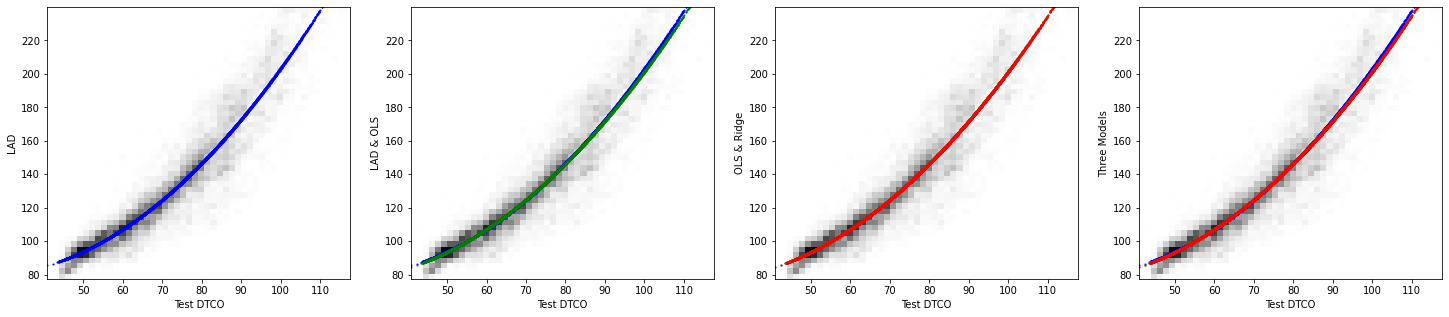

In [ ]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(25,5))

#ax1.pcolormesh(X_tr, Y_tr, H_tr,cmap='binary')

ax1.hist2d(X_test.DTCO,Y_test.DTSM,bins=50, cmap='binary')
ax1.scatter(X_test.DTCO, Y_pred_lad, s=1, color='blue')
ax1.set_xlabel("Test DTCO")
ax1.set_ylabel("LAD")

ax2.hist2d(X_test.DTCO,Y_test.DTSM,bins=50, cmap='binary')
ax2.scatter(X_test.DTCO, Y_pred_lad, s=1, color='blue')
ax2.scatter(X_test.DTCO, Y_pred_ols, s=1, color='green')
ax2.set_xlabel("Test DTCO")
ax2.set_ylabel("LAD & OLS")

ax3.hist2d(X_test.DTCO,Y_test.DTSM,bins=50, cmap='binary')
ax3.scatter(X_test.DTCO, Y_pred_ols, s=1, color='green')
ax3.scatter(X_test.DTCO, Y_pred_ridge, s=1, color='red')
ax3.set_xlabel("Test DTCO")
ax3.set_ylabel("OLS & Ridge")

ax4.hist2d(X_test.DTCO,Y_test.DTSM,bins=50, cmap='binary')
ax4.scatter(X_test.DTCO, Y_pred_lad, s=1, color='blue')
ax4.scatter(X_test.DTCO, Y_pred_ols, s=1, color='green')
ax4.scatter(X_test.DTCO, Y_pred_ridge, s=1, color='red')
ax4.set_xlabel("Test DTCO")
ax4.set_ylabel("Three Models")

plt.show()

## Error Analysis

In [ ]:
def mape(y_test, y_pred):
  y_test, y_pred = np.array(y_test), np.array(y_pred)
  return np.mean(np.abs(y_test-y_pred)/y_test)

def print_scores(name, x, y):
  print('%s:\t MSE: %.2f, R^2 Score: %.2f, MAPE: %.4f' % (name, mean_squared_error(x, y),r2_score(x, y), mape(x, y)))

In [ ]:
print_scores('LAD',Y_test.DTSM, Y_pred_lad)
print_scores('OLS',Y_test.DTSM, Y_pred_ols)
print_scores('Ridge',Y_test.DTSM, Y_pred_ridge)

LAD:	 MSE: 141.91, R^2 Score: 0.88, MAPE: 0.0600
OLS:	 MSE: 141.51, R^2 Score: 0.88, MAPE: 0.0599
Ridge:	 MSE: 141.51, R^2 Score: 0.88, MAPE: 0.0599


compare to linear vp models:

LAD:	 MSE: 163.49, R^2 Score: 0.87, MAPE: 0.0652

OLS:	 MSE: 159.12, R^2 Score: 0.87, MAPE: 0.0681

Ridge:	 MSE: 159.12, R^2 Score: 0.87, MAPE: 0.0681

Compare to vp2 and gamma, rho models:

LAD:	 MSE: 140.10, R^2 Score: 0.88, MAPE: 0.0594

OLS:	 MSE: 138.79, R^2 Score: 0.89, MAPE: 0.0596

Ridge:	 MSE: 138.79, R^2 Score: 0.89, MAPE: 0.0596

In [ ]:
err_lad = (Y_pred_lad - Y_test.DTSM).values
err_ols = (Y_pred_ols - Y_test.DTSM).values
err_ridge = (Y_pred_ridge - Y_test.DTSM).values

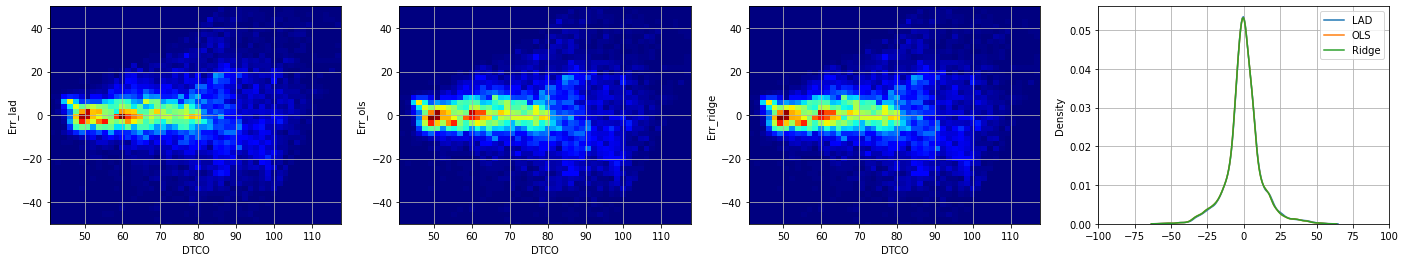

In [ ]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(24,4))

ax1.hist2d(X_test.DTCO, err_lad,bins=50, cmap='jet')
ax1.set_xlabel("DTCO")
ax1.set_ylabel("Err_lad")
ax1.set_ylim([-50,50])
ax1.grid()

ax2.hist2d(X_test.DTCO, err_ols,bins=50, cmap='jet')
ax2.set_xlabel("DTCO")
ax2.set_ylabel("Err_ols")
ax2.set_ylim([-50,50])
ax2.grid()

ax3.hist2d(X_test.DTCO, err_ridge,bins=50, cmap='jet')
ax3.set_xlabel("DTCO")
ax3.set_ylabel("Err_ridge")
ax3.set_ylim([-50,50])
ax3.grid()

sns.kdeplot(err_lad, label = "LAD", ax=ax4)
sns.kdeplot(err_ridge, label = "OLS", ax=ax4)
sns.kdeplot(err_ridge, label = "Ridge", ax=ax4)
ax4.set_xlim([-100,100])
ax4.legend()
ax4.grid()

plt.show()


## Save models

In [ ]:
filename = 'model_11_lad.sav'
pickle.dump(lad, open(filename, 'wb'))

filename = 'model_11_ridge.sav'
pickle.dump(ridge, open(filename, 'wb'))

# loaded_model = pickle.load(open(filename, 'rb'))


filename = 'scaler_x1.sav'
pickle.dump(scaler_x, open(filename, 'wb'))

## Compare to other models

Compare to models with Gamma and Rho

In [ ]:
model_09 = pickle.load(open('model_09_ridge.sav', 'rb'))

In [ ]:
cols=['GAMMA','RHO','DTCO']

X_train09, X_test09, Y_train09, Y_test09 = train_test_split(data[['GAMMA','RHO','DTCO']], data[['DTSM']], test_size=0.1, random_state=42)
scaler_x09 = preprocessing.StandardScaler().fit(X_train09)
#X_train_sc09 = scaler_x.transform(X_train)
X_test_sc09 = scaler_x09.transform(X_test09)
X_test_sc09 = np.hstack((X_test_sc09,(X_test_sc09[:,-1].reshape(-1,1))**2))

In [ ]:
Y_pred_m09 = model_09.predict(X_test_sc09)

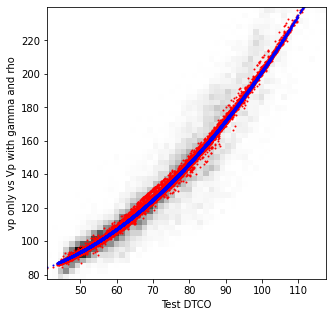

In [ ]:
f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

#ax1.pcolormesh(X_tr, Y_tr, H_tr,cmap='binary')

ax1.hist2d(X_test.DTCO,Y_test.DTSM,bins=50, cmap='binary')
ax1.scatter(X_test.DTCO, Y_pred_m09, s=1, color='red')
ax1.scatter(X_test.DTCO, Y_pred_ridge, s=1, color='blue')

ax1.set_xlabel("Test DTCO")
ax1.set_ylabel("vp only vs Vp with gamma and rho")



plt.show()

In [ ]:
err_m09 = (Y_pred_m09 - Y_test.DTSM).values

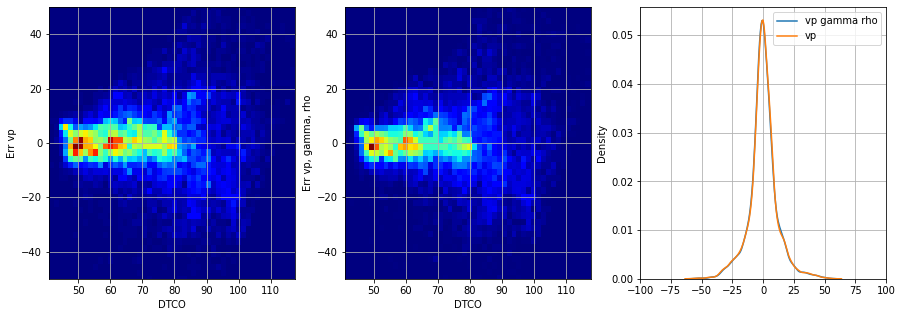

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax1.hist2d(X_test.DTCO, err_ridge,bins=50, cmap='jet')
ax1.set_xlabel("DTCO")
ax1.set_ylabel("Err vp")
ax1.set_ylim([-50,50])
ax1.grid()

ax2.hist2d(X_test.DTCO, err_m09,bins=50, cmap='jet')
ax2.set_xlabel("DTCO")
ax2.set_ylabel("Err vp, gamma, rho")
ax2.set_ylim([-50,50])
ax2.grid()

sns.kdeplot(err_m09, label = "vp gamma rho", ax=ax3)
sns.kdeplot(err_ridge, label = "vp", ax=ax3)
ax3.set_xlim([-100,100])
ax3.legend()
ax3.grid()

plt.show()


The best model (according to MSE) is Ridge with vp, vp^2, gamma, rho.

## Reference

https://towardsdatascience.com/build-your-own-custom-scikit-learn-regression-5d0d718f289


https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf